<h1 style="text-align:center;color:#0F4C81">Classification</h1>

- Training a Binary Classifier
- Performance Measures
    - Measuring Accuracy Using Cross-Validation
    - Confusion matrices
    - Precision and Recall
    - The precision/recall trade-off
    - The ROC Curve
- Multiclass Classification
- Error Analysis

The MNIST dataset consists of 70,000 small images of handwritten digits, each labeled with the corresponding digit. Widely regarded as the "hello world" of machine learning, it is commonly used to evaluate new classification algorithms and is often one of the first datasets explored by those learning machine learning. Scikit-Learn offers helper functions to download popular datasets, including MNIST, which can be fetched directly from OpenML.org using the following code.

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

The sklearn.datasets package contains mostly three types of functions: `fetch_*` functions such as `fetch_openml()` to download real-life datasets, `load_*` functions to load small toy datasets bundled with
Scikit-Learn (so they don’t need to be downloaded over the internet), and `make_*` functions to generate fake datasets, useful for tests. Generated datasets are usually returned as an `(X, y)` tuple containing the input data and the targets, both as NumPy arrays. Other datasets are returned as `sklearn.utils.Bunch` objects, which are dictionaries whose entries can also be accessed as attributes. They generally contain the following entries:

In [2]:
dir(mnist)

['DESCR',
 'categories',
 'data',
 'details',
 'feature_names',
 'frame',
 'target',
 'target_names',
 'url']

In [3]:
print(mnist['DESCR'])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

The `fetch_openml()` function is a bit unusual since by default it returns the inputs as a Pandas DataFrame and the labels as a Pandas Series (unless the dataset is sparse). But the MNIST dataset contains images, and
DataFrames aren’t ideal for that, so it’s preferable to set `as_frame=False` to get the data as NumPy arrays instead. Let’s look at these arrays:

In [4]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
print(f"{X.shape=}")
print(f"{y.shape=}")

X.shape=(70000, 784)
y.shape=(70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All we need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s `imshow()` function. We use `cmap="binary"` to get a grayscale color map where 0 is white and 255 is black

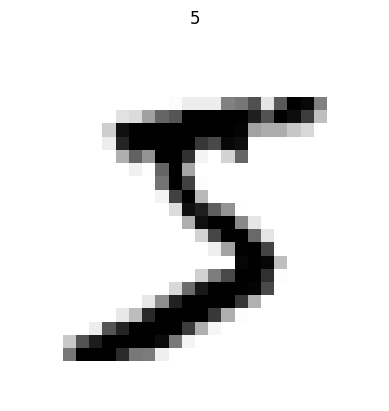

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

first_digit = X[0]
first_label = y[0]
plot_digit(first_digit)
plt.title(first_label)
plt.show()

To illustrate the complexity of the classification task, here are a few additional images from the MNIST dataset.

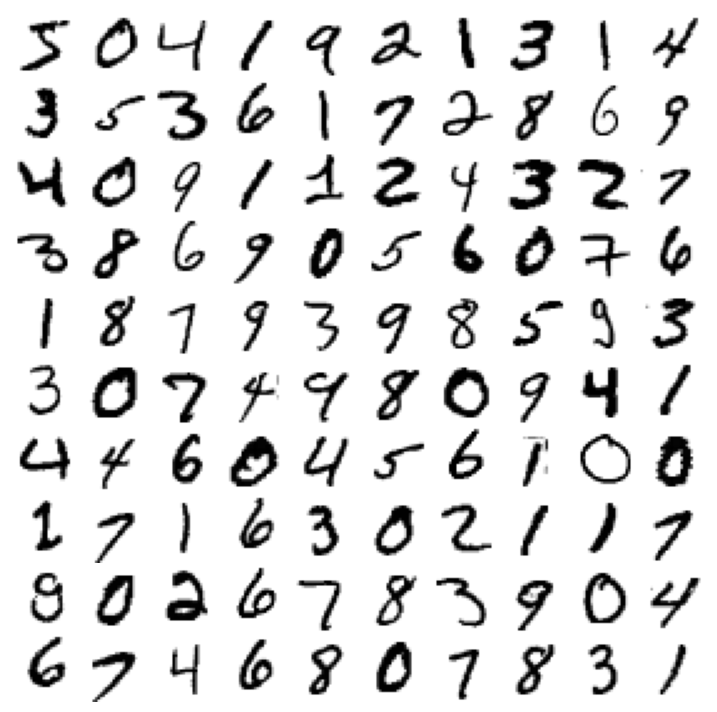

In [8]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx+1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset returned by
fetch_openml() is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because thisguarantees that all cross-validation folds will be similar (we don’t want onefold to be missing some digits). Moreover, some learning algorithms aresensitive to the order of the training instances, and they perform poorly ifthey get many similar instances in a row. Shuffling the dataset ensures thatthis won’t happen.

## Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit — for example, the number 5. This “5-detector” will be an example of a _binary classifier_, capable of distinguishing between just two classes, 5 and non-5.First we’ll create the target vectors for this classification task:

In [10]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Now let’s pick a classifier and train it. A good place to start is with a _stochastic gradient descent_ (SGD, or stochastic GD) classifier, using Scikit-Learn’s `SGDClassifier` class. This classifier is capable of handling verylarge datasets efficiently. Let’s create an `SGDClassifier` and train it on the whole training set.

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

Now we can use it to detect images of the number 5:

In [12]:
sgd_clf.predict([first_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case! Now, let’s evaluate this model’s performance.

## Performance Measures

**Measuring Accuracy Using Cross-Validation**

A good way to evaluate a model is through cross-validation. The `cross_val_score()` function can be used to assess the performance of the `SGDClassifier` model using k-fold cross-validation, with three folds in this case. K-fold cross-validation involves splitting the training set into k folds (three in this case), then training the model k times, each time holding out a different fold for evaluation.

In the case of using `cross_val_score` with the `'accuracy'` scoring parameter, the formula for accuracy is:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} = \frac{\sum (\hat{y}_i = y_i)}{N}
$$

Where:
- $\hat{y}_i$ is the predicted label for the $i$-th sample.
- $y_i$ is the true label for the $i$-th sample.
- $N$ is the total number of samples.

When you use `cross_val_score` with `scoring='accuracy'`, it computes this accuracy for each fold of the cross-validation, and then the result is an array of accuracy scores for each fold. The average of these accuracy scores represents the model's overall performance across the splits.

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.94885, 0.94935, 0.9614 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a dummy classifier that just classifies every single image in the most frequent class, which in this case is the negative class (i.e., non 5):

In [14]:
import numpy as np
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
never_5_clf.fit(X_train, y_train_5)
print(any(never_5_clf.predict(X_train)))

False


> You can use `DummyClassifier` for the same purpose.

```python
>>> from sklearn.dummy import DummyClassifier
>>> dummy_clf = DummyClassifier()
>>> dummy_clf.fit(X_train, y_train_5)
>>> print(any(dummy_clf.predict(X_train)))
False
```

Can you guess this model’s accuracy? Let’s find out:

In [15]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with _skewed datasets_ (i.e., when some classes are much more frequent than others).

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the **confusion matrix**. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch).

Instead, you can use the `cross_val_predict()` function:

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

Just like the `cross_val_score()` function, `cross_val_predict()`performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the `confusion_matrix()` function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred).

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_train_5, y_pred=y_train_pred)
cm

array([[53728,   851],
       [ 1208,  4213]])

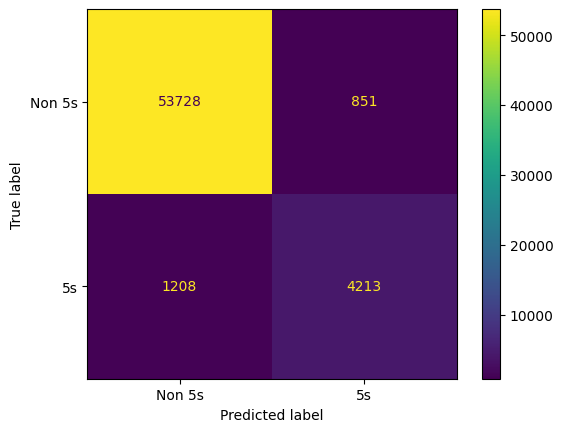

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(cm, display_labels=['Non 5s', '5s']).plot()
plt.show()

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the **precision** of the classifier.
$$
\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

- $\text{TP}$ - the number of true positives;
- $\text{FP}$ - the number of false positives.

A trivial way to have perfect precision is to create a classifier that always makes negative predictions, except for one single positive prediction on the instance it’s most confident about. If this one prediction is correct, then the classifier has 100% precision (precision = 1/1 = 100%). Obviously, such a classifier would not be very useful, since it would ignore all but one positive instance. So, precision is typically used along with another metric named **recall**, also called **sensitivity** or the **true positive rate** (TPR): this is the ratio of positive instances that are correctly detected by the classifier.

$$
\text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

- $\text{TP}$ - the number of true positives;
- $\text{FN}$ - the number of false negatives.

If you are confused about the confusion matrix, below figure may help.

<div style="display:flex;justify-content:center;align-items:center;">
<img src="images/confusion_matrix_image.png" style="width=500px;object-fit:cover;" />
</div>

Scikit-Learn provides several functions to compute classifier metrics, including **precision** and **recall**:

In [20]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
print(f'{precision=}')

precision=np.float64(0.8319510268562401)


In [21]:
recall = recall_score(y_train_5, y_train_pred)
print(f'{recall=}')

recall=np.float64(0.7771628850765542)


Now the 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 75.5% of the time. Moreover, it only detects 83.1 % of the 5s.

It is often convenient to combine precision and recall into a single metric called $F_1$ score, especially when you need a single metric to compare two classifiers. The $F_1$ score is the _harmonic mean_ of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high $F_1$ score if both recall and precision are high.

$$
F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} = \frac{\text{TP}}{\text{TP} + \frac{\text{FN}+\text{FP}}{2}}
$$

To compute the $F_1$ score, simply call the `f1_score()` function:

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

np.float64(0.8036242250834525)

The $F_1$ score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has much higher recall but treats a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier's video selection). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has 30 % precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

### Precision/Recall Trade-off

The `SGDClassifier` makes decisions using a **decision function**. If the score is above a threshold, the instance is classified as positive; otherwise, it's negative. Adjusting this threshold affects **precision and recall**:  
- **Higher threshold → More precision, less recall** (fewer false positives, but more false negatives).  
- **Lower threshold → More recall, less precision** (more true positives, but also more false positives).  

This trade-off is key in classification tasks.

<div style="display:flex;justify-content:center;align-items:center;">
<img src="images/various_thresholds.png" style="width=500px;object-fit:cover;" />
</div>

Scikit-Learn does not allow setting the classification threshold directly. However, you can access the **decision scores** using `decision_function()`, which provides a score for each instance. You can then apply a custom threshold to make predictions instead of relying on `predict()`.

In [23]:
some_digit = X[0]
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([4358.62367831])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

How do you decide which threshold to use? First, use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time
specify that you want to return decision scores instead of predictions:

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [27]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

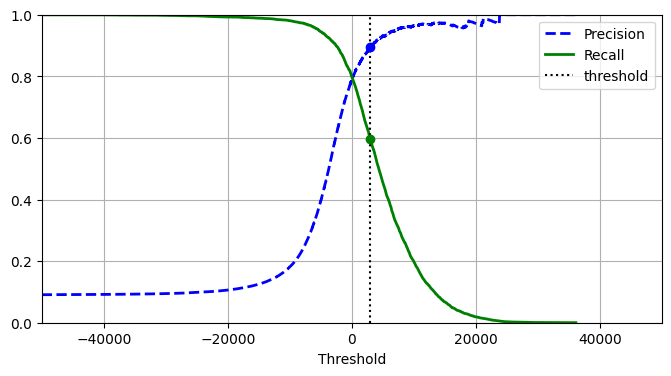

In [28]:
threshold = 3000

plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='threshold')

idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], 'bo')
plt.plot(thresholds[idx], recalls[idx], 'go')
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend()
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall:

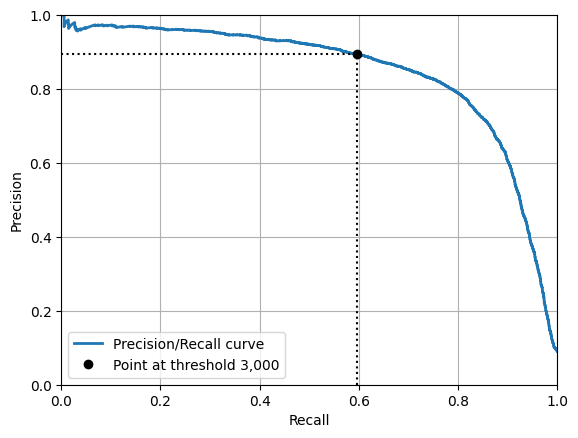

In [29]:
plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall curve')
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label=f"Point at threshold {threshold:,}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend()
plt.show()

**ROC Curve**

In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

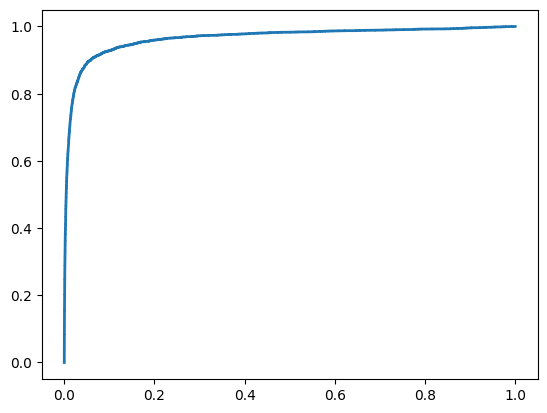

In [31]:
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.show()

One way to compare classifiers is to measure the **area under the curve** (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to estimate the ROC AUC:

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9657675886275153)

Let’s now create a `RandomForestClassifier`, whose **PR** curve and $F_1$ score we can compare to those of the `SGDClassifier`:

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [36]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [37]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [38]:
y_scores_forest = y_probas_forest[:, 1]
precision_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest
)

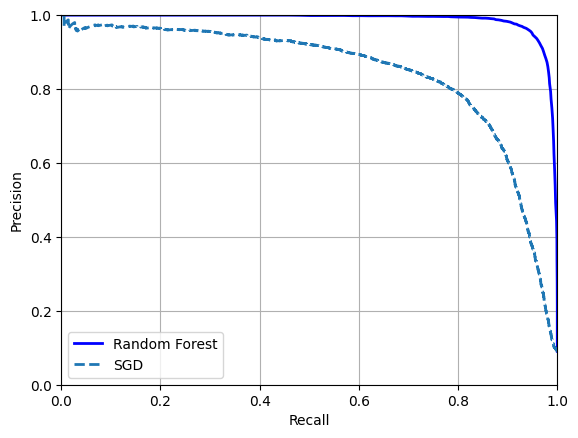

In [43]:
plt.plot(recalls_forest, precision_forest, 'b-', linewidth=2,
         label='Random Forest')
plt.plot(recalls, precisions, '--', linewidth=2, label='SGD')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.legend()
plt.grid()
plt.show()

As you can see, the `RandomForestClassifier`’s PR curve looks much better than the `SGDClassifier`’s: it comes much closer to the top-right corner. Its $F_1$ score and ROC AUC score are also significantly better:

In [44]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

np.float64(0.9274509803921569)

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

## Multiclass Classification

**Binary vs. Multiclass Classification**
- **Binary classification**: The model distinguishes between two possible classes (e.g., "spam" vs. "not spam").
- **Multiclass classification**: The model distinguishes between more than two classes (e.g., recognizing digits 0 to 9).

Some classifiers, like `LogisticRegression`, `RandomForestClassifier`, and `GaussianNB`, **natively** support multiclass classification, meaning they can directly handle multiple classes without needing modifications.  
Other classifiers, like `SGDClassifier` and `SVC`, are **strictly binary** and need a strategy to extend them for multiclass problems.

---

**One-vs-Rest (OvR) Strategy**

Also called **One-vs-All (OvA)**, this approach involves:
1. **Training one binary classifier per class**  
   - Each classifier distinguishes a single class from all the others.
   - Example: For digit recognition (0-9), train **10 classifiers**:
     - A "0-detector" (classifies between "0" and "not 0"),
     - A "1-detector" (classifies between "1" and "not 1"), etc.
2. **Making a prediction**  
   - When classifying a new image, all classifiers output a **score**.
   - The class with the **highest score** is the predicted class.

**Advantages of OvR**
- Requires training **only N classifiers** (where **N** is the number of classes).
- Works well for most classification algorithms.

**Disadvantages of OvR**
- Each classifier is trained with imbalanced data (one class vs. all others).
- Some classifiers (like SVM) may struggle with highly imbalanced datasets.

---

**One-vs-One (OvO) Strategy**
In this approach:
1. **Train one binary classifier for every pair of classes**  
   - Instead of comparing one class against all others, classifiers compare each **pair** of classes.
   - Example: For digit recognition (0-9), train **45 classifiers** (since there are **N × (N - 1) / 2** classifiers for **N** classes):
     - A "0 vs. 1" classifier
     - A "0 vs. 2" classifier
     - A "1 vs. 2" classifier, etc.
2. **Making a prediction**  
   - When classifying a new image, each classifier predicts one of the two classes it was trained on.
   - The class that wins the **most votes** across all classifiers is the final prediction.

**Advantages of OvO**
- Each classifier is trained on a **smaller subset** of the dataset (only two classes at a time).
- **Better for algorithms that scale poorly with large datasets** (like SVM), since they train faster on small subsets.

**Disadvantages of OvO**
- Requires training **many more classifiers** than OvR (especially for large **N**).
- More computationally expensive at inference time (since multiple classifiers are used to predict each new instance).

---

**When to Use OvR vs. OvO**
- **OvR** is generally preferred because it requires fewer classifiers and is simpler to train.
- **OvO** is better when using algorithms like **SVM**, which don't scale well with large datasets.

Let’s try this with a support vector machine classifier using the `sklearn.svm.SVC` class. We’ll only train on the first 2,000 images, or else it will take a very long time:

In [52]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [53]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [55]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [56]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [57]:
svm_clf.classes_[class_id]

'5'

If you want to force Scikit-Learn to use one-versus-one or one-versus-therest, you can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes. Simply create an instance and pass a classifier to its constructor (it doesn’t even have to be a binary classifier).

In [58]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [59]:
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [60]:
ovr_clf.estimators_

[SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42)]

**Error Analysis**

In [61]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))

First, look at the confusion matrix. For this, you first need to make predictions using the `cross_val_predict()` function, then you can pass the labels and predictions to the `confusion_matrix()` function. Howerver, since there are now 10 classes instead of 2, the confusion matrix will contain quite a lot of numbers, and it may be hard to read. A colored diagram of the confusion matrix is much easier to analyze. To plot such a diagram, you can use the `ConfusionMatrixDisplay.from_predictions()` function like this:

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

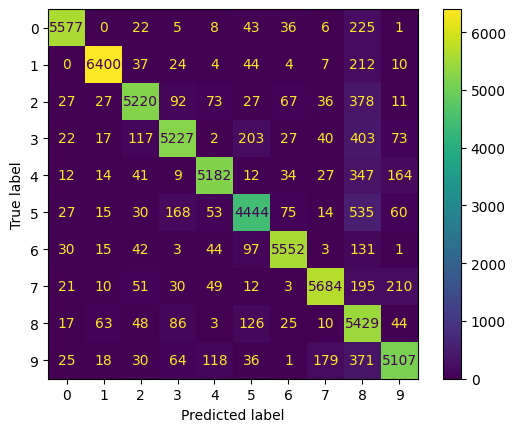

In [83]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

Notice that the cell on the diagonal on row #5 and column #5 looks slightly darker than the other digits. This could be because the model made more erros on 5s, or because there are simply less 5s in the dataset than other digits. That's why it is important to normalize the confusion matrix by dividing each value by the total number of images in the corresponding (true) class. This can be done simply by setting `normalize="true"`. We can also specify `values_format=".0%"` argument to show percentages with no decimals.

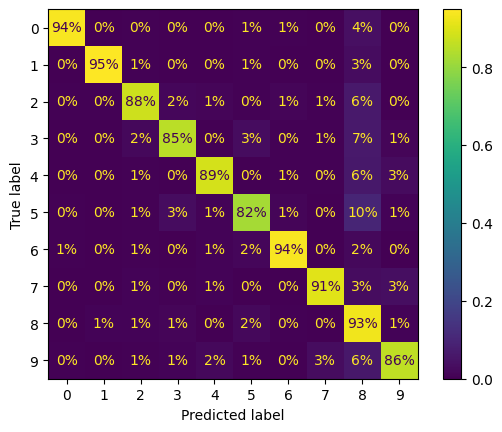

In [84]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format='.0%')
plt.show()

Now we can see that only 82% of the images of 5s were classified correcylt. The most common error the model made with images of 5s was to misclassify them as 8s: this happened for 10% of all 5s. But only 2% of 8s got misclassified as 5s: confusion matrices are generally not symmetrical! If you look carefully, you will notice that many digits have been misclassified as 8s, but this is not immedietely obvious on this diagram. If you want to make the errors stand out much more, you can try putting zero weight on the correct predictions.

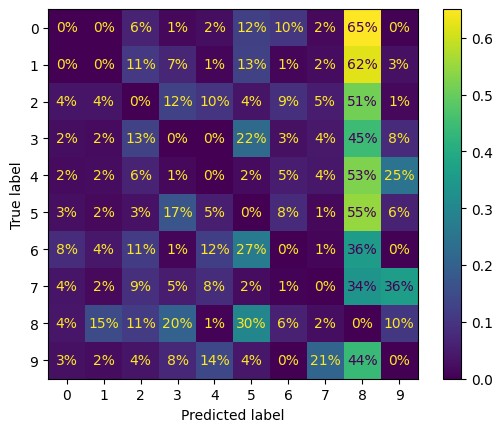

In [91]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='true', values_format='.0%')
plt.show()

Now you can see much more clearly the kinds of errors the classifier makes. The column for class 8 is now really bright, which confirms that many images got misclassified as 8s. In fact this is the most common misclassification for almost all classes. But be caraful how you interpret the percentages on this diagram: remember that we've excluded the correct predictions. For example, the 36% in row #7, column #9 does not mean that 36% all all images of 7s were misclassified as 9s. It means that 36% of the errors the model made on images of 7s we misclassifications as 9s. In realitym inly 3% of images of 7s were misclassified as 9s.

It is also possible to normalize the confusion matrix by column rather than by row by simply setting `normalize="pred"`.

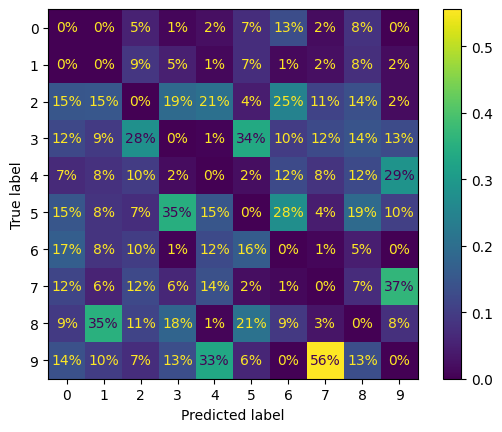

In [92]:
ConfusionMatrixDisplay.from_predictions(
    y_train, y_train_pred,
    normalize='pred',
    values_format='.0%',
    sample_weight=sample_weight
)
plt.show()

You can see that 56% if misclassified 7s are actually 9s.